In [3]:
%matplotlib inline
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

RuntimeError: module compiled against API version a but this version of numpy is 9

# Introduction
Let's do a simple E-B separation and kappa reconstruction using Healpy routines only.
One might think that it is trivial but there is actually a number of subtelties on the way, 
such as appropriately band-limiting the maps and constructing adequate masks to mitigate the EB leakage.
As you will see the results are far from perfect but this approach has the advantage of being very simple.
I am currently finishing a piece of code + paper that does this at very high resolution,
completely bypassing Healpix and strictly removing the EBleakage using a multi-scale wavelet masking.
This will allow to use much more sky that what's described below.
Boris

# References
The implementation below is based on the equations/formalism of
- http://arxiv.org/abs/astro-ph/0503479
- http://arxiv.org/abs/1509.06750
and references therein.

In [337]:
# Read files and mask them
QU_mask = hp.read_map('maps/micev2_imaglt225_ns1024_mask.fits')
T_map = hp.read_map('maps/micev2_imaglt225_ns1024_count.fits')
kappatrue_inputmap = hp.read_map('maps/micev2_imaglt225_ns1024_kappa.fits')
Q_map = hp.read_map('maps/micev2_imaglt225_ns1024_gamma1.fits') 
U_map = hp.read_map('maps/micev2_imaglt225_ns1024_gamma2.fits')

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [338]:
# Compute E and B from Q+iU and Q-iU on the full sky (no handling of mask)
# Function is not used below but could be
def compute_EB_from_QU(QpU_lm, QmU_lm, L):
    E_lm = np.zeros(QpU_lm.shape, dtype=complex)
    B_lm = np.zeros(QmU_lm.shape, dtype=complex)
    for el in range(L):
        for em in range(L):
            ind = hp_ind_lm(el, em, L)
            E_lm[ind] = - (QpU_lm[ind] + QmU_lm[ind]) / 2.0
            B_lm[ind] = 1j * (QpU_lm[ind] - QmU_lm[ind]) / 2.0
    return E_lm, B_lm

Sigma is 8.957691 arcmin (0.002606 rad) 
-> fwhm is 21.093750 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 8.957691 arcmin (0.002606 rad) 
-> fwhm is 21.093750 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 2.239423 arcmin (0.000651 rad) 
-> fwhm is 5.273438 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


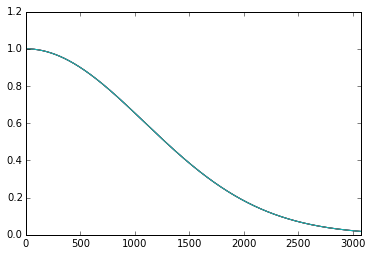

In [339]:
# Compute 1D index to navigate Healpy a_lm coefficients (L is the band-limit)
def hp_ind_lm(el, em, L):
    return em*(2*L-1-em)/2+el

# Define parameters
nside = 1024 
L = 3*nside # should be at least 2*nside, if possible between 3 and 5 nside.
lmax = L-1 # just renaming for clarity/consistency with healpy
fwhm = 0.5 * np.pi / nside # smoothing size (don't ask how I picked this... arXiv:1306.0005)
bl = hp.gauss_beam(fwhm, lmax=lmax, pol=True)
plt.plot(bl**2)
plt.xlim([0, lmax])
#stop

# Construct smoothed and extended masks to keep quasi-leakage-free regions of the sky
threshold = 0.99
mask_lm = hp.map2alm(QU_mask, lmax=lmax, pol=False) # scalar transform
mask_lm_sm = hp.smoothalm(mask_lm, fwhm=4*fwhm) # extra smoothing of the mask to deal with edges
mask_sm = hp.alm2map(mask_lm_sm, nside=1024, lmax=lmax, pol=False) # mask at adequate resolusion
mask_sm_t = 1*mask_sm
mask_sm_t[mask_sm >= threshold] = 1
mask_sm_t[mask_sm < threshold] = 0
mask_lm_sm2 = hp.map2alm(mask_sm_t, lmax=lmax, pol=False) # scalar transform
_ = hp.smoothalm(mask_lm_sm2, fwhm=4*fwhm, inplace=True) # extra smoothing of the mask to deal with edges
mask_sm2 = hp.alm2map(mask_lm_sm2, nside=nside, lmax=lmax, pol=False) # mask at adequate resolusion
mask = 1*mask_sm2
mask[mask < threshold] = 0
mask[mask > threshold] = 1

# Do EB separation using Healpy, even though there will be leakage near mask
KQU_masked_maps = [kappatrue_inputmap*mask_sm, Q_map*mask_sm, U_map*mask_sm]
almsnosm = hp.map2alm(KQU_masked_maps, lmax=lmax, pol=True) # Spin transform!
[kappatrue_lm, E_lm, B_lm] = hp.smoothalm(almsnosm, fwhm=fwhm) # extra smoothing of the mask to deal with edges

# Scalar transform to get E-B maps (at smaller resolution than input)
kappatrue_map = hp.alm2map(kappatrue_lm, nside=nside, lmax=lmax, pol=False) 
E_map = hp.alm2map(E_lm, nside=nside, lmax=lmax, pol=False) 
B_map = hp.alm2map(B_lm, nside=nside, lmax=lmax, pol=False) 

# For cosmic shear, I implicitly define 
# QpU = (gamma1 + i*gamma2) and QmU = (gamma1 - i*gamma2)
# CMB polarization is a little bit different, 
# i.e. the convention/normalisation will differ

In [340]:
# Get the reconstructed shear phi and kappa fields from the reconstructed E
ellfac = np.zeros(E_lm.shape)
for el in range(L):
    for em in range(L):
        ellfac[hp_ind_lm(el, em, L)] = el
phiE_lm = - 2 * E_lm / np.sqrt((ellfac+2)*(ellfac+1)*(ellfac)*(ellfac-1))
phiE_lm[np.isnan(phiE_lm)] = 0
kappa_lm = - ellfac * (ellfac + 1) * phiE_lm / 2.
kappa_lm[np.isnan(kappa_lm)] = 0
kappa_map = hp.alm2map(kappa_lm, nside=nside, lmax=lmax, pol=False)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/Users/bl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


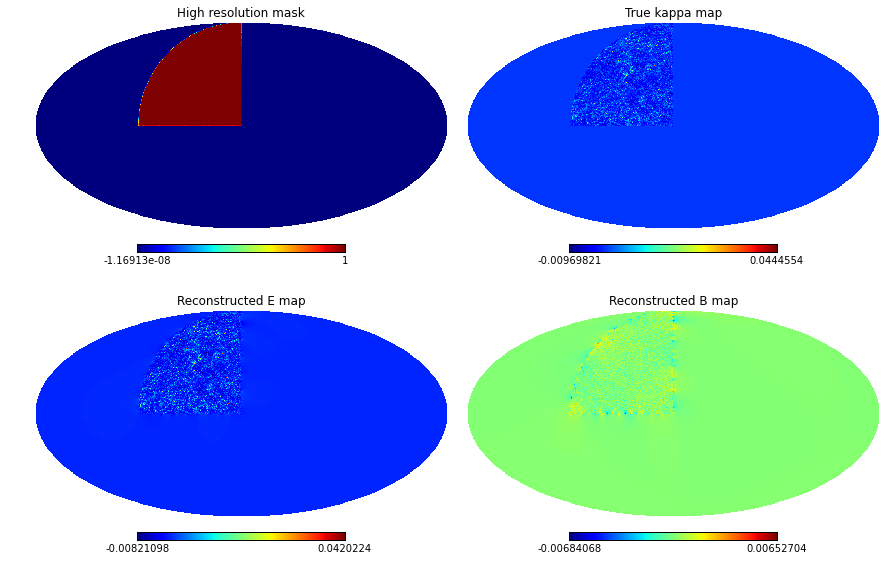

In [341]:
# plots of full sky maps
# these *will have EB leakage* near the edges of the mask.
fig = plt.figure(figsize=(12, 8))
hp.mollview(mask_sm, sub=221, title='High resolution mask')
hp.mollview(kappatrue_map, sub=222, title='True kappa map')
hp.mollview(E_map, sub=223, title='Reconstructed E map')
hp.mollview(B_map, sub=224, title='Reconstructed B map')

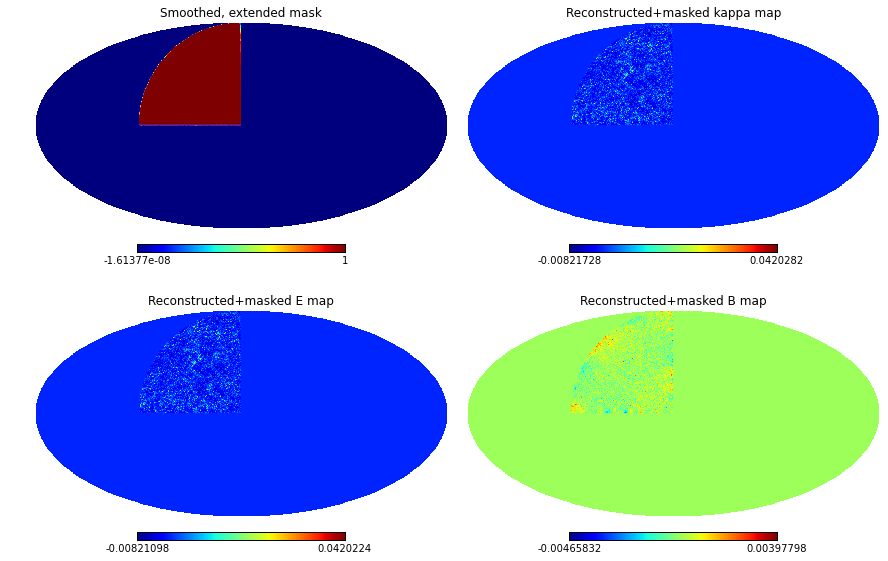

In [342]:
# plots of masked sky maps
# the mask has been extended to mitigate the EB leakage near the edges of the mask.
# but of course this is very crude and better techniques exist.
fig = plt.figure(figsize=(12, 8))
hp.mollview(mask_sm2, sub=221, title='Smoothed, extended mask')
hp.mollview(kappa_map*mask_sm2, sub=222, title='Reconstructed+masked kappa map')
hp.mollview(E_map*mask_sm2, sub=223, title='Reconstructed+masked E map')
hp.mollview(B_map*mask_sm2, sub=224, title='Reconstructed+masked B map')

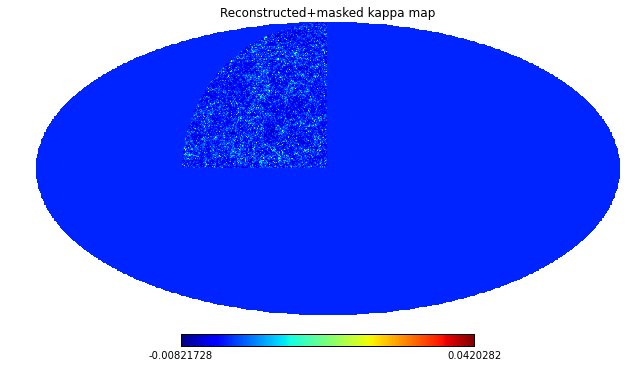

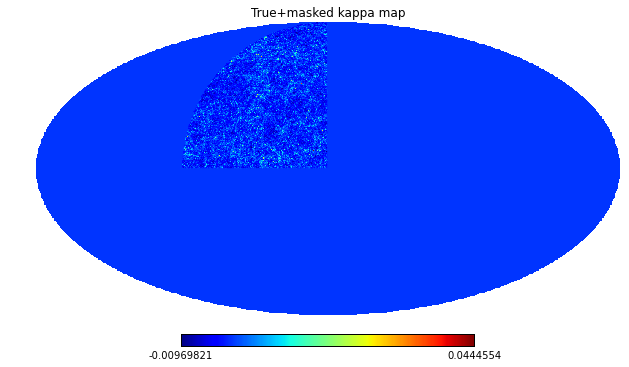

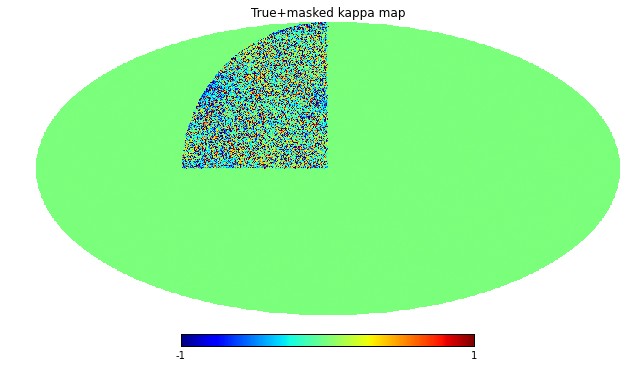

In [343]:
hp.mollview(kappa_map*mask_sm2, title='Reconstructed+masked kappa map')
hp.mollview(kappatrue_map*mask_sm2, title='True+masked kappa map')
hp.mollview((kappa_map/kappatrue_map-1)*mask_sm2, min=-1, max=1, title='True+masked kappa map')

In [344]:
# Compute a few metrics
ind = np.where(mask >= 0.9)[0]
relerr = kappa_map[ind]/kappatrue_map[ind] - 1
kappatrue_cl, kappa_lm_masked = hp.anafast(kappatrue_map*mask, lmax=lmax, alm=True)
kappa_cl, kappatrue_lm_masked = hp.anafast(kappa_map*mask, lmax=lmax, alm=True)
relerr_lm = np.abs(kappa_lm_masked[2:]/kappatrue_lm_masked[2:] - 1)
relerr_cl = kappa_cl/kappatrue_cl - 1

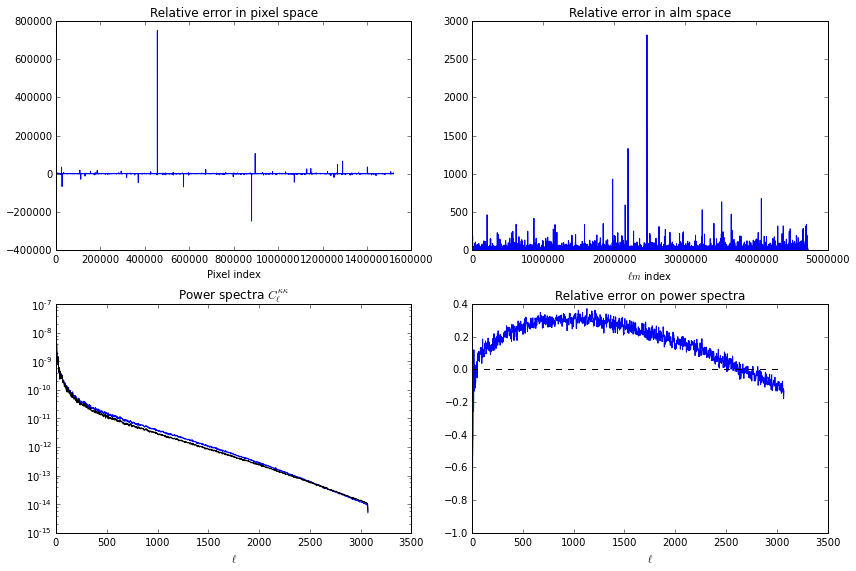

In [345]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.ravel()

axs[0].plot(relerr)
axs[0].set_title('Relative error in pixel space')
axs[0].set_xlabel('Pixel index')

axs[1].plot(np.abs(relerr_lm))
axs[1].set_title('Relative error in alm space')
axs[1].set_xlabel('$\ell m$ index')
#axs[1].set_ylim([m2-3*s2, m2+3*s2])

axs[2].plot(kappa_cl, c='b')
axs[2].plot(kappatrue_cl, c='k')
axs[2].set_yscale('log')
axs[2].set_title('Power spectra $C^{\kappa\kappa}_\ell$')
axs[2].set_ylabel('')
axs[2].set_xlabel('$\ell$')

axs[3].plot(relerr_cl, c='b')
axs[3].plot(kappa_cl*0, c='k', ls='dashed')
axs[3].set_title('Relative error on power spectra')
axs[3].set_xlabel('$\ell$')
fig.tight_layout()

# Conclusions
The results are not too bad, but I couldn't find how to reduce the errors further.
This residual 20% offset in the power spectra is probably due to something Healpy did to the maps.
This could go away by doing the E-B separation manually from Q+iU and Q-iU maps. 
Unfortunately Healpy cannot do spin +-2 transforms so other codes must be used.
I have a piece of code that does that but relies on external libraries so I couldn't include it here.